# Clustering & sub-clustering example

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

## 1.   Loading the Dataframe with pandas ->

In [14]:
pd.set_option("display.max.rows", 10)
pd.set_option("display.max.columns", 43)
missing_values = ["N/a", "na", np.nan] # Those are treated as 'NaN' as well

#? To get rid of the warning that shows up
dtype_dict = {
    '_id': int,
    'Area_of_Origin': str,
    'Building_Status': str,
    'Business_Impact': str,
    'Civilian_Casualties': float,
    'Count_of_Persons_Rescued': float,
    'Estimated_Dollar_Loss': float,
    'Estimated_Number_Of_Persons_Displaced': float,
    'Exposures': float,
    'Ext_agent_app_or_defer_time': str,
    'Extent_Of_Fire': str,
    'Final_Incident_Type': str,
    'Fire_Alarm_System_Impact_on_Evacuation': str,
    'Fire_Alarm_System_Operation': str,
    'Fire_Alarm_System_Presence': str,
    'Fire_Under_Control_Time': str,
    'Ignition_Source': str,
    'Incident_Number': str,
    'Incident_Station_Area': str,
    'Incident_Ward': float,
    'Initial_CAD_Event_Type': str,
    'Intersection': str,
    'Last_TFS_Unit_Clear_Time': str,
    'Latitude': float,
    'Level_Of_Origin': str,
    'Longitude': float,
    'Material_First_Ignited': str,
    'Method_Of_Fire_Control': str,
    'Number_of_responding_apparatus': float,
    'Number_of_responding_personnel': float,
    'Possible_Cause': str,
    'Property_Use': str,
    'Smoke_Alarm_at_Fire_Origin': str,
    'Smoke_Alarm_at_Fire_Origin_Alarm_Failure': str,
    'Smoke_Alarm_at_Fire_Origin_Alarm_Type': str,
    'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation': str,
    'Smoke_Spread': str,
    'Sprinkler_System_Operation': str,
    'Sprinkler_System_Presence': str,
    'Status_of_Fire_On_Arrival': str,
    'TFS_Alarm_Time': str,
    'TFS_Arrival_Time': str,
    'TFS_Firefighter_Casualties': float
}
###---
# url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/64a26694-01dc-4ec3-aa87-ad8509604f50/resource/1e824947-d73b-4f48-9bac-7f7f3731"
# df = pd.read_csv(url, dtype=dtype_dict, na_values = missing_values)
df = pd.read_csv("Fire Incidents Data.csv", dtype=dtype_dict, na_values = missing_values)

#? Size: 29425 rows × 43 columns

## 2. Pre-processing / Cleaning the Data ->

In [15]:
# Remove only the rows that are all NaN (still 29425 rows × 43 columns, no row has only NaN)
df.dropna(how="all") 
# Removing exposure because of high NaN count and the sprinkler because I wont use it.
df = df.drop(columns=['Exposures', 'Sprinkler_System_Operation', 'Sprinkler_System_Presence'])

# Checking for Duplicates
df.duplicated()
df.drop_duplicates(keep="first", inplace=True)

# Handling dates
date_columns = ['TFS_Alarm_Time', 'Fire_Under_Control_Time', 'Last_TFS_Unit_Clear_Time', 'TFS_Arrival_Time', 'Ext_agent_app_or_defer_time']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
# df.info()

## 3. Preperation for k-means ->

In [16]:

#? Going to drop rows where Latitude and Longtitude are 0/NaN because I won't need them.
#* Longitude = Geographical length of nearest major or minor intersection in the ward of the incident
#* Latitude = Geographical width of the nearest major or minor intersection in the periphery of the incident

df = df.dropna(subset=['Latitude', 'Longitude']) 
df = df[(df['Latitude'] != 0) & (df['Longitude'] != 0)] #dropping rows with the value '0' on Latitude and Longitude

## 2. Using the elbow method to find the optimal 'k' ->

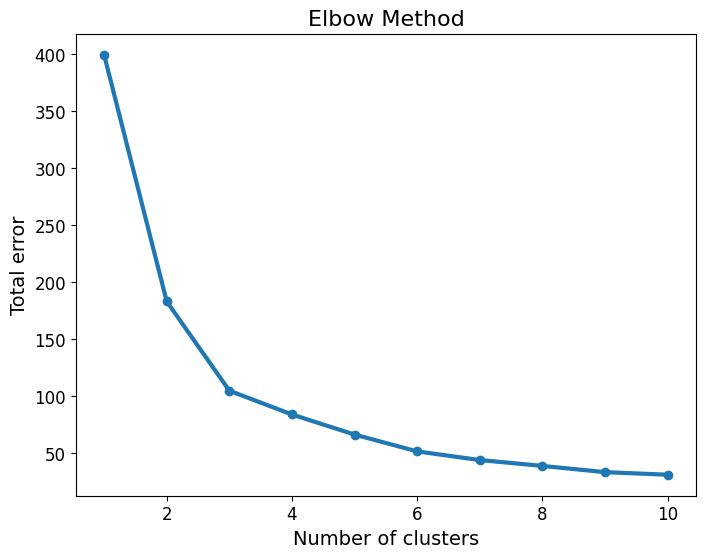

In [17]:

#? Calculate total error for different numbers of clusters with K-Means
err_total = []
n_clusters = 10

df_elbow = df[['Latitude', 'Longitude']]

for i in range(1, n_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_elbow)
    err_total.append(kmeans.inertia_)

### Plotting 
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range(1, n_clusters + 1), err_total, linewidth=3, marker='o')
ax.set_xlabel("Number of clusters", fontsize=14)
ax.set_ylabel("Total error", fontsize=14)
ax.set_title("Elbow Method", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

- *Based on the Elbow method, I can see that the "elbow" is formed on the number 3 hence I am going to use k = 3.

## 3. Executing k-Means with `k = 3` ->

In [18]:
#? This Dataset contains Latitude values from [42 to 45] and Longitude from [-80 to -76] 
# 3 Clusters will be made, each one represating an area of Toronto
kmeans = df[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=3, random_state=0)
df['Locations_Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']]) # Adds a new column that contains the Cluster value
centroids = kmeans.cluster_centers_


#? Based on google: 
#* Downtown Toronto is approximate at: 43.6400 to 43.6544 Latitude / -79.3802 to -79.3802 Longtitude
#* North York Toronto is approximate at: 43.65 to 43.80 Latitude / -79.40 to -79.30 Longtitude
#* Scarborough Toronto is approximate at: 43.65 to 43.85 Latitude / -79.20 to -79.10 Longtitude
# So I will map each cluster with it's corresponding area name by creating another column
cluster_labels = {
    0: 'Downtown',
    1: 'North York',
    2: 'Scarborough'
}

df['Location_Name'] = df['Locations_Cluster'].map(cluster_labels)

## 4. Result visualization as a plot ->

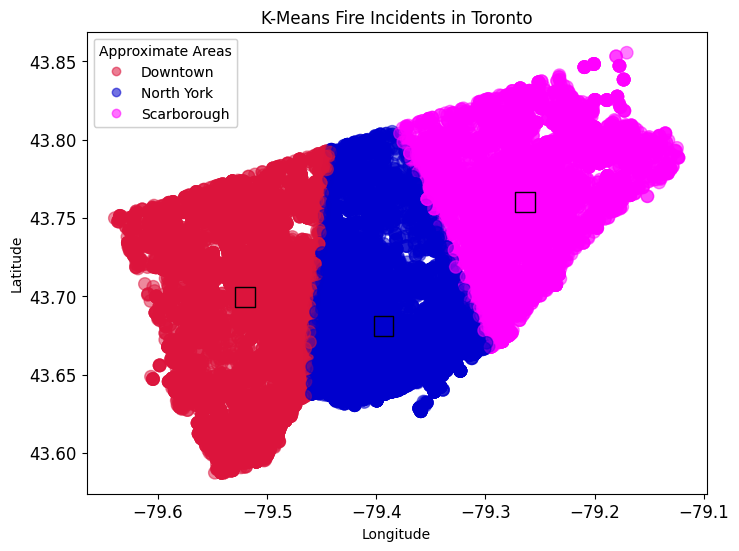

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
customcmap = ListedColormap(["crimson", "mediumblue", "magenta"])
scatter = ax.scatter(df['Longitude'], df['Latitude'], c=df['Locations_Cluster'], cmap=customcmap, s=80, alpha=0.5)

ax.scatter(centroids[:, 1], centroids[:, 0], 
marker='s', s=200, c=[0, 1, 2], cmap=customcmap, edgecolor='black')

ax.set_title('K-Means Fire Incidents in Toronto')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

handles, _ = scatter.legend_elements()
labels = [cluster_labels[i] for i in range(3)]
legend1 = ax.legend(handles, labels, title="Approximate Areas")
ax.add_artist(legend1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 5. Creating Sub-Dataframes based on the Clusters ->

In [20]:

#? Create Sub-Dataframes for each location

downtown_df = df[df['Location_Name'] == 'Downtown']
north_york_df = df[df['Location_Name'] == 'North York']
scarborough_df = df[df['Location_Name'] == 'Scarborough']

# Filtering out the value '99'
downtown_df = downtown_df[downtown_df['Possible_Cause'] != '99 - Undetermined']
north_york_df = north_york_df[north_york_df['Possible_Cause'] != '99 - Undetermined']
scarborough_df = scarborough_df[scarborough_df['Possible_Cause'] != '99 - Undetermined']

## 6. Sample analysis on the Possible cause (No clustering yet) -> 

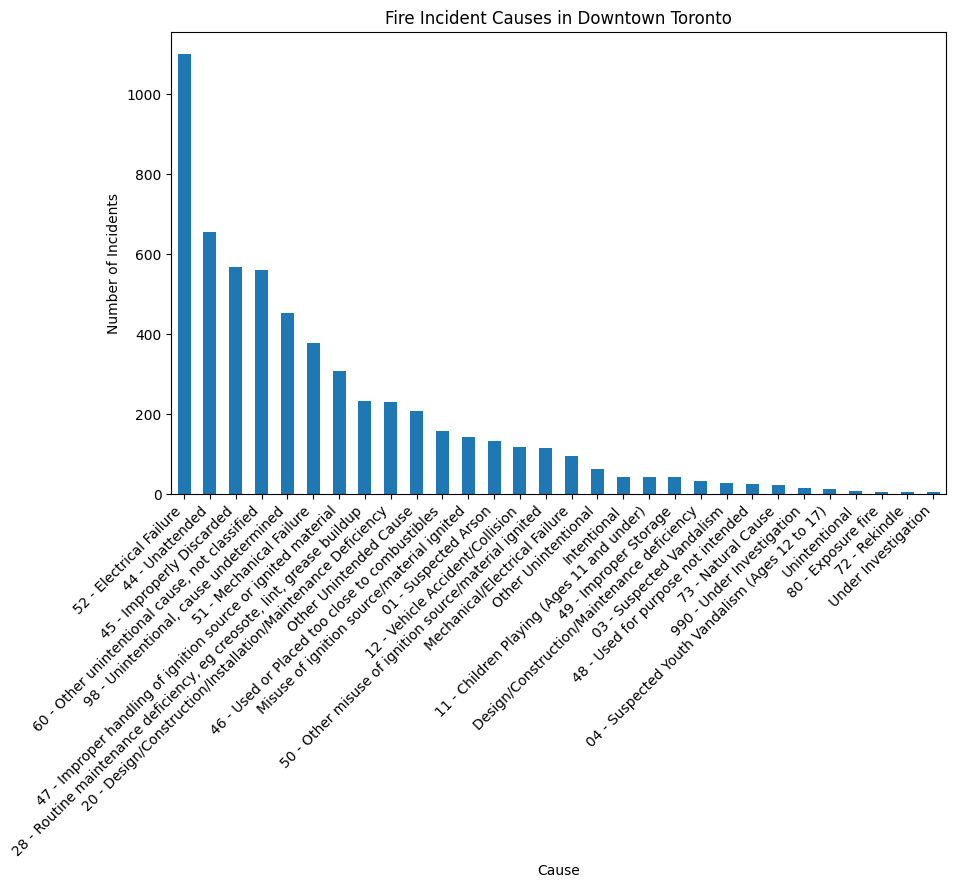

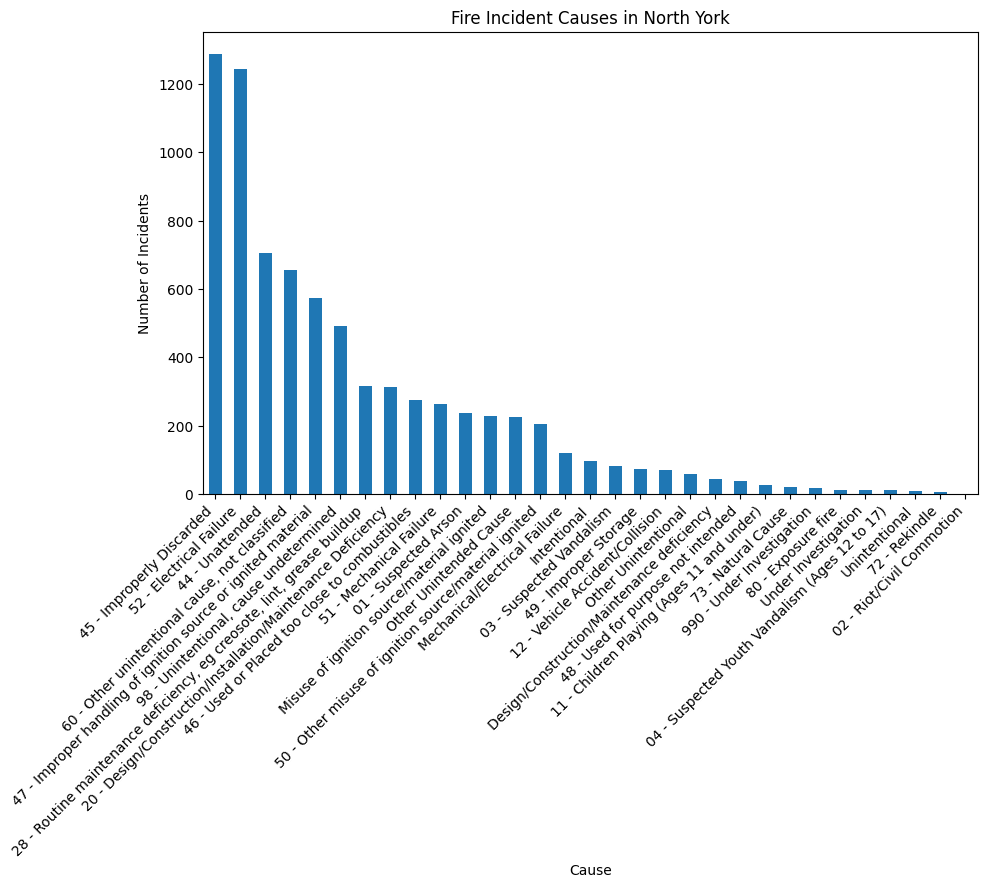

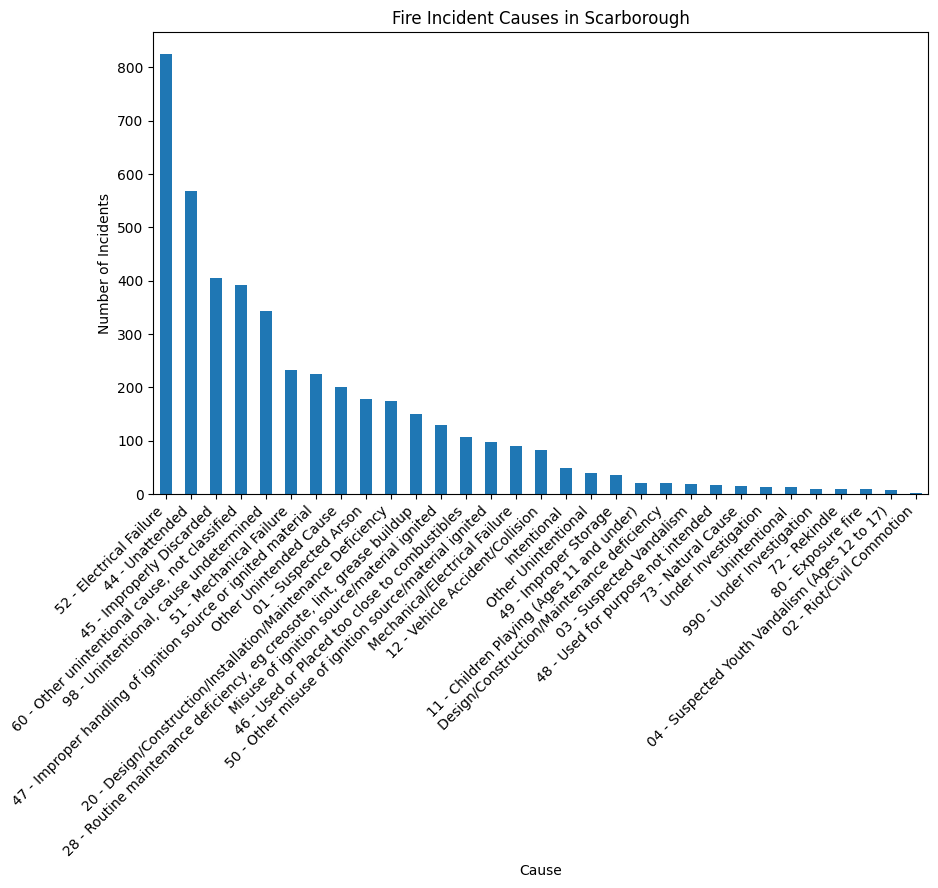

In [21]:
def plot_fire_causes(causes, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    causes.plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Cause')
    ax.set_ylabel('Number of Incidents')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
##--

downtown_causes = downtown_df['Possible_Cause'].value_counts()
north_york_causes = north_york_df['Possible_Cause'].value_counts()
scarborough_causes = scarborough_df['Possible_Cause'].value_counts()

plot_fire_causes(downtown_causes, 'Fire Incident Causes in Downtown Toronto')
plot_fire_causes(north_york_causes, 'Fire Incident Causes in North York')
plot_fire_causes(scarborough_causes, 'Fire Incident Causes in Scarborough')

#* That shows me that in Downtown and Scarborough the most common cause is: Electrical failure, on 1000+ and 800+ incedents respectively.
#* As for the most incedents, North York is first with 1200+ and most of them are: Improperly discarded materials??

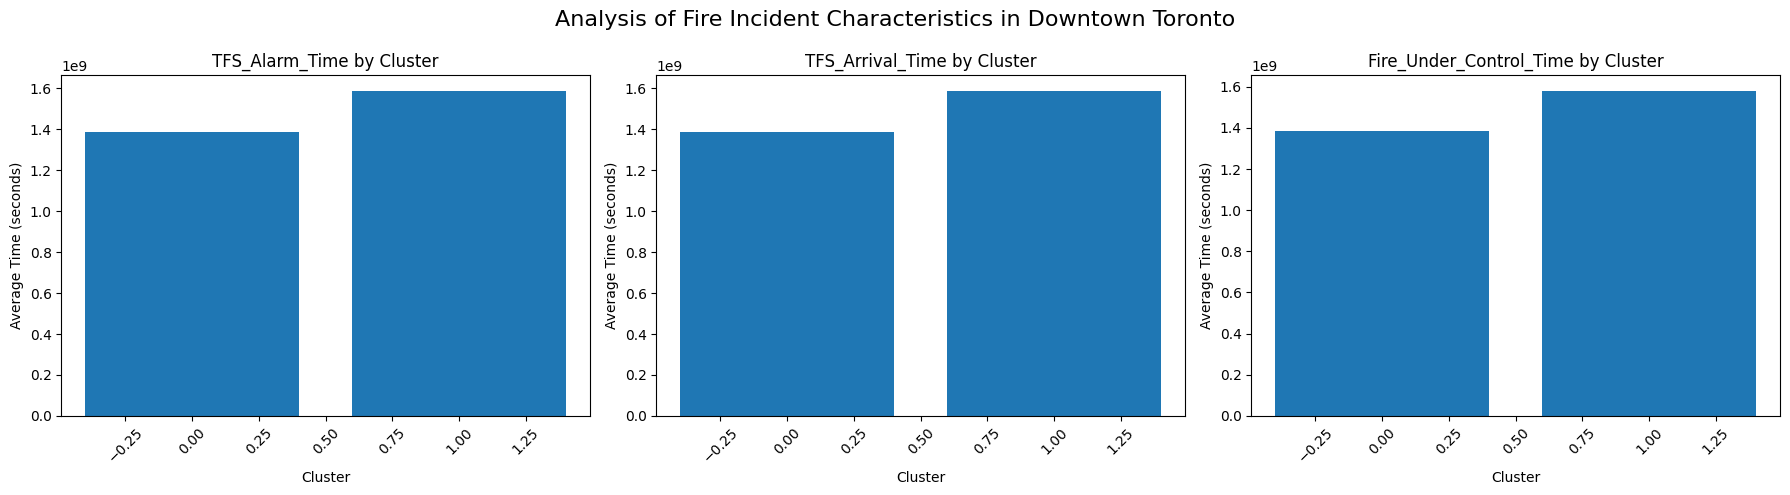

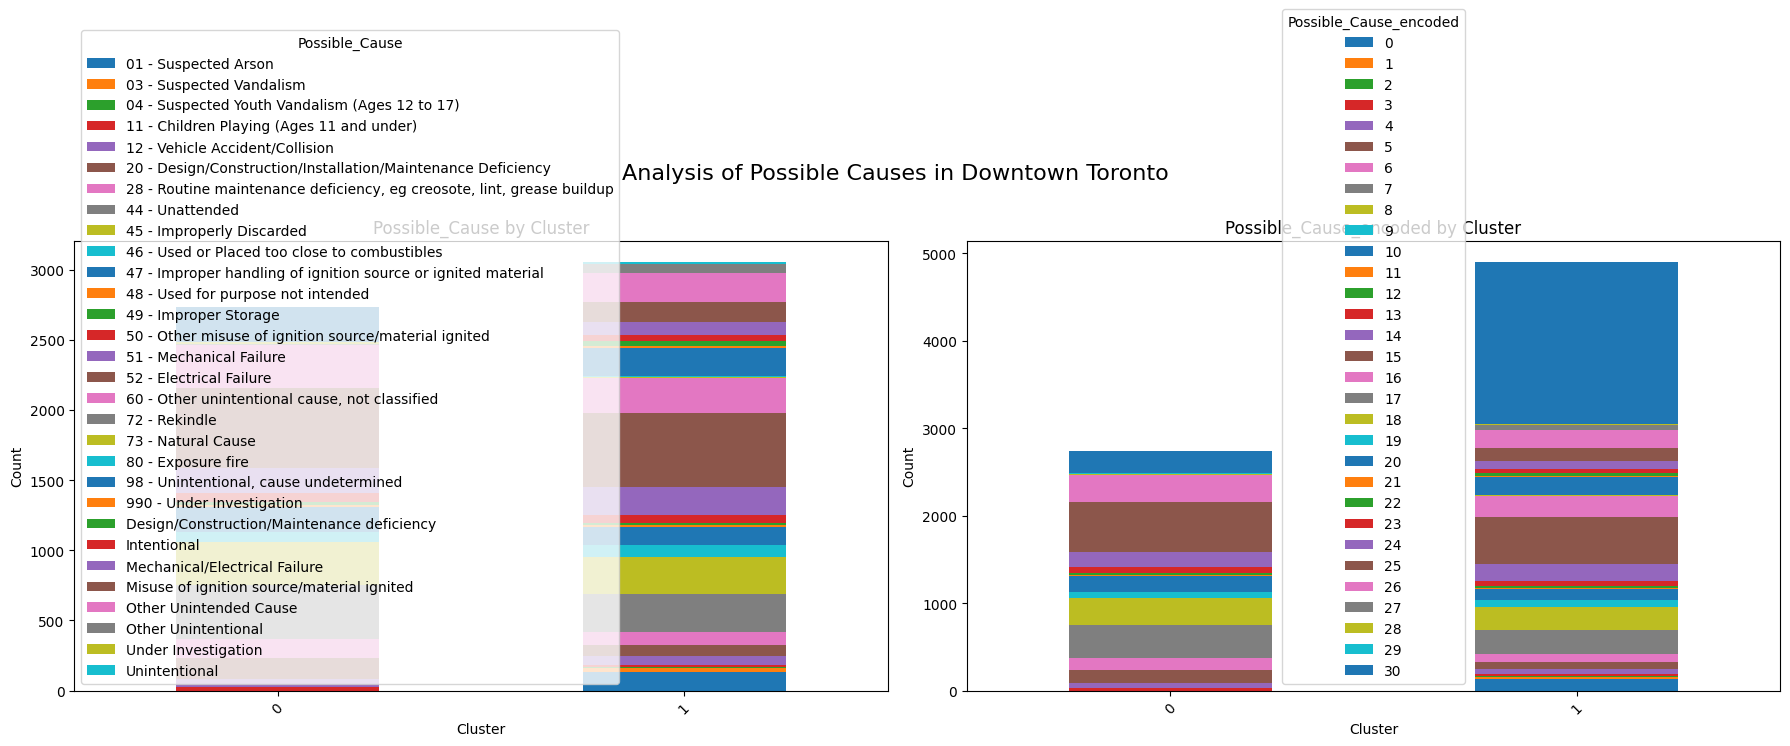

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

def perform_kmeans_clustering(data, datetime_columns, cause_column, k):
    # Convert datetime columns to numeric features
    for col in datetime_columns:
        data[col + '_numeric'] = (data[col] - pd.Timestamp('1970-01-01')) // pd.Timedelta(seconds=1)
    
    # Encode the possible cause column
    le = LabelEncoder()
    data[cause_column + '_encoded'] = le.fit_transform(data[cause_column])
    
    # Combine all features for clustering
    feature_columns = [col + '_numeric' for col in datetime_columns] + [cause_column + '_encoded']
    
    # Handle missing values in feature columns
    imputer = SimpleImputer(strategy='mean')  # Impute NaN values with mean
    data_imputed = imputer.fit_transform(data[feature_columns])
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    data['Cluster'] = kmeans.fit_predict(data_imputed)
    
    return data

# Define columns for clustering and analysis
datetime_columns = ['TFS_Alarm_Time', 'TFS_Arrival_Time', 'Fire_Under_Control_Time']
cause_column = 'Possible_Cause'
k_clusters = 2  # Number of clusters for KMeans

# Perform KMeans clustering for each sub-dataframe
downtown_clustered = perform_kmeans_clustering(downtown_df, datetime_columns, cause_column, k_clusters)
north_york_clustered = perform_kmeans_clustering(north_york_df, datetime_columns, cause_column, k_clusters)
scarborough_clustered = perform_kmeans_clustering(scarborough_df, datetime_columns, cause_column, k_clusters)

# Function to plot results for analysis
def plot_analysis(df, location_name, datetime_columns, cause_column):
    # Plot for each datetime column by cluster
    fig, axs = plt.subplots(1, len(datetime_columns), figsize=(18, 5))
    fig.suptitle(f'Analysis of Fire Incident Characteristics in {location_name}', fontsize=16)

    for i, col in enumerate(datetime_columns):
        # Average time for each cluster
        avg_time = df.groupby('Cluster')[f'{col}_numeric'].mean()
        ax = axs[i]
        ax.bar(avg_time.index, avg_time.values)
        ax.set_title(f'{col} by Cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Average Time (seconds)')
        ax.tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.subplots_adjust(top=0.85)  # Adjust top margin for the title
    plt.show()

    # Plot for Possible Cause by cluster
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Analysis of Possible Causes in {location_name}', fontsize=16)

    # Plot for Possible Cause
    cause_counts = df.groupby('Cluster')[cause_column].value_counts().unstack().fillna(0)
    cause_counts.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f'{cause_column} by Cluster')
    axs[0].set_xlabel('Cluster')
    axs[0].set_ylabel('Count')
    axs[0].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability

    # Remove legend for 'possible_cause_encoded' if it exists
    axs[0].legend().remove()

    # Plot for Possible Cause Encoded (if available)
    if f'{cause_column}_encoded' in df.columns:
        cause_encoded_counts = df.groupby('Cluster')[f'{cause_column}_encoded'].value_counts().unstack().fillna(0)
        cause_encoded_counts.plot(kind='bar', stacked=True, ax=axs[1])
        axs[1].set_title(f'{cause_column}_encoded by Cluster')
        axs[1].set_xlabel('Cluster')
        axs[1].set_ylabel('Count')
        axs[1].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability

        # Remove legend for 'possible_cause_encoded'
        axs[1].legend().remove()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.subplots_adjust(top=0.85)  # Adjust top margin for the title
    plt.show()

# Plot analysis for Downtown
plot_analysis(downtown_clustered, 'Downtown Toronto', datetime_columns, cause_column)

# Plot analysis for North York
# plot_analysis(north_york_clustered, 'North York Toronto', datetime_columns, cause_column)

# # Plot analysis for Scarborough
# plot_analysis(scarborough_clustered, 'Scarborough Toronto', datetime_columns, cause_column)

# To CSV

In [43]:
# # Save into CSV
# path = 'processed_fire_incidents.csv'
# df.to_csv(path, index=False)

# print(f"Cleaned dataset has been saved to: {path}")